ECE4191 - Team E04

## Multi-Category Model


Single-class detection

In [1]:
!pip install -q --upgrade tensorflow==2.17.0 tensorflow-io
!pip install numpy==1.26.4 pandas==2.1.4 --force-reinstall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.4/601.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 76.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 74.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 73.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 99.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.8 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatib

In [1]:
import os
import glob
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio
import matplotlib.pyplot as plt
from IPython import display
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from google.colab import files
import zipfile

In [2]:
@tf.function
def load_wav_16k_mono(filename):
  """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
  file_contents = tf.io.read_file(filename)
  wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
  wav = tf.squeeze(wav, axis=-1)
  sample_rate = tf.cast(sample_rate, dtype=tf.int64)
  wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
  return wav

def extract_embedding(wav_data, label):
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings, tf.repeat(label, num_embeddings))

In [3]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [4]:
import zipfile

!unzip -q /content/augmented_data/augmented_kookaburra.zip -d /content/augmented_data
!unzip -q /content/augmented_data/augmented_bat.zip -d /content/augmented_data
!unzip -q /content/augmented_data/augmented_cockatoo.zip -d /content/augmented_data
!unzip -q /content/augmented_data/augmented_crocodile.zip -d /content/augmented_data
!unzip -q /content/augmented_data/augmented_dingo.zip -d /content/augmented_data
!unzip -q /content/augmented_data/augmented_duck.zip -d /content/augmented_data
!unzip -q /content/augmented_data/augmented_frog.zip -d /content/augmented_data
!unzip -q /content/augmented_data/augmented_koala.zip -d /content/augmented_data
!unzip -q /content/augmented_data/augmented_magpie.zip -d /content/augmented_data
!unzip -q /content/augmented_data/augmented_platypus.zip -d /content/augmented_data
!unzip -q /content/augmented_data/augmented_possum.zip -d /content/augmented_data
!unzip -q /content/augmented_data/augmented_snake.zip -d /content/augmented_data
!unzip -q /content/augmented_data/augmented_tawnyfrogmouth.zip -d /content/augmented_data
!unzip -q /content/augmented_data/augmented_wombat.zip -d /content/augmented_data
!unzip -q /content/augmented_data/augmented_background.zip -d /content/augmented_data

In [5]:
import glob
import pandas as pd
import os

my_classes = ['kookaburra', 'bat', 'cockatoo', 'crocodile', 'dingo', 'duck', 'frog', 'koala', 'magpie', 'platypus', 'possum', 'snake', 'tawnyfrogmouth', 'wombat', 'background']  # Multi-class
base_data_path = '/content/augmented_data/'

filenames = glob.glob(base_data_path + '**/*.wav', recursive=True)  # Recursive to handle subfolders

targets = []
valid_filenames = []
for f in filenames:
    basename = os.path.basename(f).lower()
    matching_c = next((c for c in my_classes if c in basename), None)
    if matching_c:
        valid_filenames.append(f)
        targets.append(my_classes.index(matching_c))

my_pd_data = pd.DataFrame({'filename': valid_filenames, 'target': targets}).astype({'filename': 'object'})
print(len(valid_filenames))  # Debug: Should be combined total from all classes
my_pd_data.head()

16824


,filename,target
0,/content/augmented_data/augmented_duck/DUCK4_a...,5
1,/content/augmented_data/augmented_duck/DUCK7_a...,5
2,/content/augmented_data/augmented_duck/DUCK10_...,5
3,/content/augmented_data/augmented_duck/DUCK9_a...,5
4,/content/augmented_data/augmented_duck/DUCK5_a...,5


In [6]:
# Split filenames first (fast)
from sklearn.model_selection import train_test_split

filenames = my_pd_data['filename'].tolist()
targets = my_pd_data['target'].tolist()

train_files, test_files, train_targets, test_targets = train_test_split(filenames, targets, test_size=0.2, stratify=targets, random_state=42)
train_files, val_files, train_targets, val_targets = train_test_split(train_files, train_targets, test_size=0.125, stratify=train_targets, random_state=42)

# Create subsets and map/extract/cache
train_ds = tf.data.Dataset.from_tensor_slices((train_files, train_targets)).map(lambda f, l: (load_wav_16k_mono(f), l)).map(extract_embedding).unbatch().cache()
val_ds = tf.data.Dataset.from_tensor_slices((val_files, val_targets)).map(lambda f, l: (load_wav_16k_mono(f), l)).map(extract_embedding).unbatch().cache()
test_ds = tf.data.Dataset.from_tensor_slices((test_files, test_targets)).map(lambda f, l: (load_wav_16k_mono(f), l)).map(extract_embedding).unbatch().cache()

# Batch/prefetch with shuffle for train
train_ds = train_ds.shuffle(10000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)

In [12]:
# Compute class weights for imbalance
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(targets), y=targets)
class_weight_dict = dict(enumerate(class_weights))

my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024,), dtype=tf.float32, name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(15)  # Explicitly 15 for 15 classes
], name='animal_model')

my_model.summary()

my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=["accuracy"])

Model: "animal_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 15)             │         7,695 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 532,495 (2.03 MB)

 Trainable params: 532,495 (2.03 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Verify targets range
print(f"Targets min/max: {min(targets)}, {max(targets)}")  # Should be 0 to 14 for 15 classes

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)

steps_per_epoch = len(train_files) // 32  # Ensure all train data is used per epoch

history = my_model.fit(train_ds,
                       epochs=20,
                       validation_data=val_ds,
                       callbacks=[callback, lr_callback],
                       class_weight=class_weight_dict,
                       steps_per_epoch=steps_per_epoch)

Targets min/max: 0, 14
Epoch 1/20


InvalidArgumentError: Graph execution error:

Detected at node GatherV2 defined at (most recent call last):
<stack traces unavailable>
Error in user-defined function passed to MapDataset:31 transformation with iterator: Iterator::Root::Prefetch::ParallelMapV2: indices[8] = 14 is not in [0, 13)
	 [[{{node GatherV2}}]]
	 [[IteratorGetNext]] [Op:__inference_multi_step_on_iterator_18719]

In [ ]:
# Loss plot
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Accuracy plot
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

# Test evaluation
test_results = my_model.evaluate(test_ds, return_dict=True)
print(test_results)

In [ ]:
# Upload and test new file
uploaded = files.upload()
new_file = list(uploaded.keys())[0]

waveform = load_wav_16k_mono(new_file)
scores, embeddings, spectrogram = yamnet_model(waveform)
result = my_model(embeddings).numpy()
probs = tf.nn.softmax(result.mean(axis=0)).numpy()  # Softmax for probabilities
threshold = 0.5  # Tune lower if misses
if np.max(probs) < threshold:
    print("Detected: unknown (low confidence)")
else:
    inferred_idx = np.argmax(probs)
    inferred_class = my_classes[inferred_idx]
    top_prob = probs[inferred_idx]
    print(f"Detected: {inferred_class} (probability: {top_prob:.2f})")

Saving possum.wav to possum (2).wav
The main sound is: bat (probability: 0.89)


In [ ]:
my_model.save('animal_model_v2.keras')
files.download('animal_model_v2.keras')

Simultaneous Detection

In [ ]:
!pip install -q --upgrade tensorflow==2.17.0 tensorflow-io
!pip install numpy==1.26.4 pandas==2.1.4 --force-reinstall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.4/601.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 86.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 84.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 111.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 75.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.8 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompati

In [ ]:
import os
import glob
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio
import matplotlib.pyplot as plt
from IPython import display
from sklearn.model_selection import train_test_split
from google.colab import files
import zipfile

In [ ]:
@tf.function
def load_wav_16k_mono(filename):
  """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
  file_contents = tf.io.read_file(filename)
  wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
  wav = tf.squeeze(wav, axis=-1)
  sample_rate = tf.cast(sample_rate, dtype=tf.int64)
  wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
  return wav

def extract_embedding(wav_data, label):
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings, tf.repeat(tf.expand_dims(label, axis=0), num_embeddings, axis=0))  # Repeat multi-hot vector

In [ ]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [ ]:
import zipfile

!unzip -q /content/augmented_data/augmented_kookaburra.zip -d /content/augmented_data
!unzip -q /content/augmented_data/augmented_bat.zip -d /content/augmented_data
!unzip -q /content/augmented_data/augmented_cockatoo.zip -d /content/augmented_data
!unzip -q /content/augmented_data/augmented_crocodile.zip -d /content/augmented_data
!unzip -q /content/augmented_data/augmented_dingo.zip -d /content/augmented_data
!unzip -q /content/augmented_data/augmented_duck.zip -d /content/augmented_data
!unzip -q /content/augmented_data/augmented_frog.zip -d /content/augmented_data
!unzip -q /content/augmented_data/augmented_koala.zip -d /content/augmented_data
!unzip -q /content/augmented_data/augmented_magpie.zip -d /content/augmented_data
!unzip -q /content/augmented_data/augmented_platypus.zip -d /content/augmented_data
!unzip -q /content/augmented_data/augmented_possum.zip -d /content/augmented_data
!unzip -q /content/augmented_data/augmented_snake.zip -d /content/augmented_data
!unzip -q /content/augmented_data/augmented_tawnyfrogmouth.zip -d /content/augmented_data
!unzip -q /content/augmented_data/augmented_wombat.zip -d /content/augmented_data
!unzip -q /content/augmented_data/augmented_background.zip -d /content/augmented_data

In [ ]:
import glob
import pandas as pd
import os
import random  # Ensure imported

my_classes = ['kookaburra', 'bat', 'cockatoo', 'crocodile', 'dingo', 'duck', 'frog', 'koala', 'magpie', 'platypus', 'possum', 'snake', 'tawnyfrogmouth', 'wombat', 'background']
base_data_path = '/content/augmented_data/'

# Group files by class (dict for mixing)
class_files = {}
for c in my_classes:
    class_files[c] = glob.glob(os.path.join(base_data_path, f'augmented_{c}', '*.wav'))  # Assuming subfolders like augmented_kookaburra/

print({c: len(files) for c, files in class_files.items()})  # Debug totals

{'kookaburra': 600, 'bat': 550, 'cockatoo': 550, 'crocodile': 400, 'dingo': 250, 'duck': 300, 'frog': 200, 'koala': 250, 'magpie': 450, 'platypus': 100, 'possum': 300, 'snake': 50, 'tawnyfrogmouth': 350, 'wombat': 450, 'background': 1080}


In [ ]:
from sklearn.model_selection import train_test_split

# Mixing parameters (tune these)
mix_prob = 0.5  # Probability a sample is mixed
max_mixes = 2   # Max additional animals per mix

# Function to generate mixed samples (files + multi-hot labels)
def generate_mixed_samples(class_files, my_classes, samples_per_class=1000):  # Increase for larger dataset
    all_files = []  # List of [file1, file2, ...] for each sample
    all_labels = []  # Multi-hot np arrays
    for c in my_classes:
        class_idx = my_classes.index(c)
        for _ in range(samples_per_class):
            if random.random() < mix_prob:
                num_other = random.randint(1, max_mixes)
                other_classes = random.sample([oc for oc in my_classes if oc != c and oc != 'background'], num_other)  # Exclude background or include optionally
                mix_files = [random.choice(class_files[c])] + [random.choice(class_files[oc]) for oc in other_classes]
                mix_label = np.zeros(len(my_classes), dtype=np.float32)
                mix_label[class_idx] = 1.0
                for oc in other_classes:
                    mix_label[my_classes.index(oc)] = 1.0
                all_files.append(mix_files)
                all_labels.append(mix_label)
            else:
                single_file = [random.choice(class_files[c])]
                single_label = np.zeros(len(my_classes), dtype=np.float32)
                single_label[class_idx] = 1.0
                all_files.append(single_file)
                all_labels.append(single_label)
    return all_files, all_labels

# Generate
all_files, all_labels = generate_mixed_samples(class_files, my_classes)

# Split
train_files, test_files, train_labels, test_labels = train_test_split(all_files, all_labels, test_size=0.2, random_state=42)  # No stratify needed for multi-label
train_files, val_files, train_labels, val_labels = train_test_split(train_files, train_labels, test_size=0.125, random_state=42)

# Function to load and mix waveforms
@tf.function
def load_and_mix(files, label):
    num = tf.shape(files)[0]

    def load1():
        w1 = load_wav_16k_mono(files[0])
        return w1 / 1.0  # Normalize by count

    def load2():
        w1 = load_wav_16k_mono(files[0])
        w2 = load_wav_16k_mono(files[1])
        len1 = tf.shape(w1)[0]
        len2 = tf.shape(w2)[0]
        max_len = tf.maximum(len1, len2)
        w1 = tf.pad(w1, [[0, max_len - len1]])
        w2 = tf.pad(w2, [[0, max_len - len2]])
        return (w1 + w2) / 2.0

    def load3():
        w1 = load_wav_16k_mono(files[0])
        w2 = load_wav_16k_mono(files[1])
        w3 = load_wav_16k_mono(files[2])
        len1 = tf.shape(w1)[0]
        len2 = tf.shape(w2)[0]
        len3 = tf.shape(w3)[0]
        max_len = tf.maximum(len1, tf.maximum(len2, len3))
        w1 = tf.pad(w1, [[0, max_len - len1]])
        w2 = tf.pad(w2, [[0, max_len - len2]])
        w3 = tf.pad(w3, [[0, max_len - len3]])
        return (w1 + w2 + w3) / 3.0

    mixed = tf.switch_case(num - 1, branch_fns=[load1, load2, load3])

    # Optional: Pad/trim to fixed length
    fixed_length = 160000  # ~10s at 16kHz; adjust to your max clip length
    current_len = tf.shape(mixed)[0]
    if current_len > fixed_length:
        mixed = mixed[:fixed_length]
    else:
        mixed = tf.pad(mixed, [[0, fixed_length - current_len]])

    return mixed, label

# Generators for datasets
def train_generator():
    for f, l in zip(train_files, train_labels):
        yield f, l

def val_generator():
    for f, l in zip(val_files, val_labels):
        yield f, l

def test_generator():
    for f, l in zip(test_files, test_labels):
        yield f, l

# Datasets: Map to mix, then extract embeddings
train_ds = tf.data.Dataset.from_generator(train_generator, output_types=(tf.string, tf.float32), output_shapes=(tf.TensorShape([None]), tf.TensorShape([len(my_classes)])))
train_ds = train_ds.map(load_and_mix, num_parallel_calls=tf.data.AUTOTUNE).map(extract_embedding).unbatch().cache().batch(32).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_generator(val_generator, output_types=(tf.string, tf.float32), output_shapes=(tf.TensorShape([None]), tf.TensorShape([len(my_classes)])))
val_ds = val_ds.map(load_and_mix, num_parallel_calls=tf.data.AUTOTUNE).map(extract_embedding).unbatch().cache().batch(32).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_generator(test_generator, output_types=(tf.string, tf.float32), output_shapes=(tf.TensorShape([None]), tf.TensorShape([len(my_classes)])))
test_ds = test_ds.map(load_and_mix, num_parallel_calls=tf.data.AUTOTUNE).map(extract_embedding).unbatch().cache().batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024,), dtype=tf.float32, name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(my_classes), activation='sigmoid')  # Sigmoid for multi-label
], name='animal_model')

my_model.summary()

my_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),  # Binary for multi-label
                 optimizer="adam",
                 metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

Model: "animal_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 15)             │         7,695 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 532,495 (2.03 MB)

 Trainable params: 532,495 (2.03 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

history = my_model.fit(train_ds,
                       epochs=20,
                       validation_data=val_ds,
                       callbacks=[callback])

Epoch 1/20
   6562/Unknown 868s 132ms/step - binary_accuracy: 0.8938 - loss: 0.3252 - precision_1: 0.7055 - recall_1: 0.1652

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


6563/6563 ━━━━━━━━━━━━━━━━━━━━ 988s 150ms/step - binary_accuracy: 0.8938 - loss: 0.3252 - precision_1: 0.7055 - recall_1: 0.1653 - val_binary_accuracy: 0.9018 - val_loss: 0.2982 - val_precision_1: 0.8247 - val_recall_1: 0.2303
Epoch 2/20
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - binary_accuracy: 0.9075 - loss: 0.2823 - precision_1: 0.8316 - recall_1: 0.2634 - val_binary_accuracy: 0.9053 - val_loss: 0.2901 - val_precision_1: 0.8390 - val_recall_1: 0.2603
Epoch 3/20
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - binary_accuracy: 0.9108 - loss: 0.2728 - precision_1: 0.8455 - recall_1: 0.2906 - val_binary_accuracy: 0.9066 - val_loss: 0.2876 - val_precision_1: 0.8396 - val_recall_1: 0.2734
Epoch 4/20
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 82s 12ms/step - binary_accuracy: 0.9128 - loss: 0.2663 - precision_1: 0.8528 - recall_1: 0.3081 - val_binary_accuracy: 0.9076 - val_loss: 0.2866 - val_precision_1: 0.8391 - val_recall_1: 0.2841
Epoch 5/20
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - binary_acc

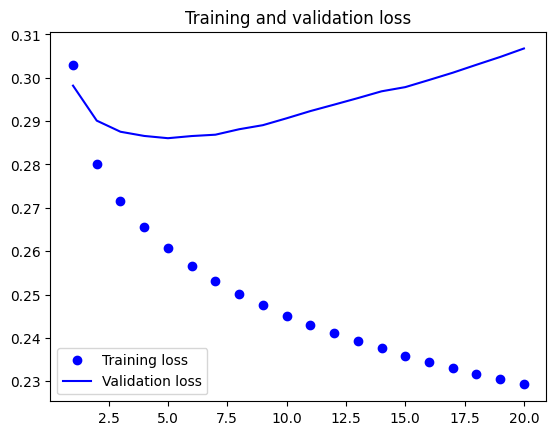

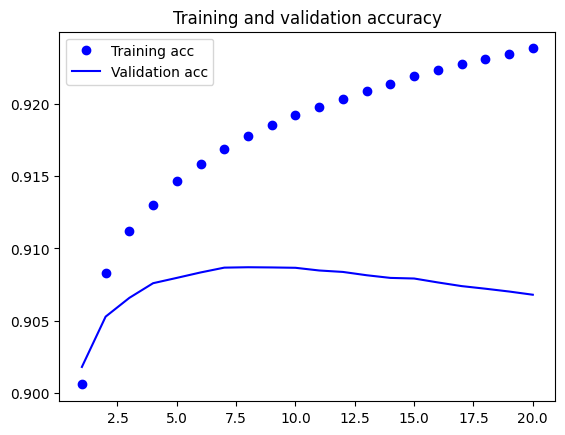

    736/Unknown 95s 127ms/step - binary_accuracy: 0.9114 - loss: 0.2955 - precision_1: 0.7616 - recall_1: 0.3436

KeyboardInterrupt: 

In [ ]:
# Loss plot
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Binary Accuracy plot (update key if needed)
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

# Test evaluation
test_results = my_model.evaluate(test_ds, return_dict=True)
print(test_results)

In [ ]:
# Upload and test new file
uploaded = files.upload()
new_file = list(uploaded.keys())[0]

waveform = load_wav_16k_mono(new_file)
scores, embeddings, spectrogram = yamnet_model(waveform)
result = my_model(embeddings).numpy()  # Logits
probs = tf.sigmoid(result.mean(axis=0)).numpy()  # Sigmoid probabilities
threshold = 0.5  # Tune this
detected_indices = np.where(probs > threshold)[0]
detected_classes = [my_classes[i] for i in detected_indices]
detected_probs = probs[detected_indices]

if len(detected_classes) == 0:
    print("No detections above threshold.")
else:
    print(f"Detected: {', '.join(detected_classes)} (probabilities: {', '.join(f'{p:.2f}' for p in detected_probs)})")

In [ ]:
my_model.save('animal_model_multi.keras')
files.download('animal_model_multi.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>